In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pyplot as plt
from sklearn import preprocessing

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
sys.path.append("../helpers/")
sys.path.append("../helpers/utils")
sys.path.append("../helpers/central")
import utils
import sparse_linreg_peeling

torch.set_num_threads(1)
torch.set_printoptions(precision=16) # default

%load_ext autoreload
%autoreload 2

## Utils

In [246]:
def parse_dataset(path, normalize_params):
    df = pd.read_csv(path)

    # normalize between (-a, b)
    a, b = normalize_params
    for column in df.columns:
        df[column] = a + ((df[column] - df[column].min()) * (b - a) / (df[column].max() - df[column].min()))
                              
    return df

## Data from the peeling paper (8 features, but used only for lin reg)

In [ ]:
df = pd.read_csv('../data/cadata.txt')
df = df.head(2000)
df = df.drop(df.columns[0], axis=1)
df.shape

In [ ]:
# copy the data 
df2 = df.copy()
  
# apply normalization techniques 
for column in df2.columns: 
    df2[column] = (df2[column] -
                           df2[column].mean()) / df2[column].std()     
  
# view normalized data    
display(df2)

In [ ]:
df2.head()

In [ ]:
Y = df2['target']
X = df2.drop(df2.columns[0], axis=1)

In [ ]:
Y

In [ ]:
Y = Y.fillna(0)
X = X.fillna(0)

In [ ]:
lreg = LinearRegression().fit(X, Y)
coef = lreg.coef_
coef

In [ ]:
# Closed form solution
theta_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y.T) # or np.linalg.lstsq(X, Y)
theta_star

In [ ]:
z_coef = Y - (X @ coef)
z_coef = torch.from_numpy(z_coef.to_numpy())
e = torch.norm(z_coef, p=2)
e

In [ ]:
z_theta = Y - (X @ theta_star)
z_theta = torch.from_numpy(z_theta.to_numpy())
e = torch.norm(z_theta, p=2)
e

In [ ]:
def compute_noise_scale(s, eta, n, sigma):
    # set constants
    c0 = 1
    cx = 1
    R = sigma * np.sqrt(2 * np.log(n))

    # compute B and lambda
    # B can be larger than this, but the smallest scale had B equal to this
    B = 4 * (R + cx * c0) * (cx / np.sqrt(s))
    lmb = eta * (B / n)
    return B, lmb

In [ ]:
T = 500
eta = 0.1
result = {}
n, d = X.shape[0], X.shape[1]

X_tensor = torch.from_numpy(X.to_numpy())
Y_tensor = torch.from_numpy(Y.to_numpy())
theta_star_tensor = torch.from_numpy(theta_star)

data = (X_tensor, Y_tensor, theta_star_tensor)

for k in [8, 5, 2]:
    _, lmb = compute_noise_scale(k, eta, n, 1)

    # SLR non-private
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (_, _, _, False))
    result[(k, 'non-private')] = it_err
    print(f'[no noise] k={k}, last_err={last_err}')

    # SLR private
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (lmb, T * 5, 1 / n, True))
    result[(k, 'private')] = it_err
    print(f'[with noise] k={k}, last_err={last_err}')

In [ ]:
utils.plot_error_by_iteration_and_dict_key(
    result,
    title=f'Iterations error, central, n={n}, d={d}, eta={eta}, dataset CADATA',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(k, dp)")

## Data energy farm (148 features)

In [121]:
def compute_noise_scale(s, eta, n, sigma):
    # set constants
    c0 = 1
    cx = 1
    R = sigma * np.sqrt(2 * np.log(n))

    # compute B and lambda
    # B can be larger than this, but the smallest scale had B equal to this
    B = 4 * (R + cx * c0) * (cx / np.sqrt(s))
    lmb = eta * (B / n)
    return B, lmb

In [168]:
df_energy = pd.read_csv('../data/energy.csv')
df_energy.shape

(36043, 149)

In [169]:
df_energy.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power42,Power43,Power44,Power45,Power46,Power47,Power48,Power49,qW,Total_Power
0,600.0,0.0,546.16,37.50,489.79,74.88,432.47,112.05,650.0,0.0,...,88867.92,98844.30,101283.59,98934.63,101624.58,100915.03,99625.68,96704.34,0.87,4102461.43
1,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88896.55,98759.79,101346.07,98873.59,101629.01,100934.53,99606.13,96718.39,0.87,4103361.41
2,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88919.83,98746.68,101346.15,98875.57,101618.32,100941.00,99611.35,96719.14,0.87,4103680.44
3,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88855.14,98760.96,101338.59,98971.58,101632.28,100943.59,99589.25,96735.04,0.87,4105661.06
4,200.0,0.0,146.17,37.53,89.76,74.93,32.40,112.18,400.0,0.0,...,88005.30,98630.24,100432.73,98803.01,101064.48,100948.38,99028.87,96286.71,0.79,3752648.77


In [170]:
# copy the data 
df_energy2 = df_energy.copy() 
  
# apply normalization techniques 
# for column in df_energy2.columns: 
#     df_energy2[column] = (df_energy2[column] -
#                            df_energy2[column].mean()) / df_energy2[column].std()     

a, b = -1, 1
for column in df_energy2.columns:
    df_energy2[column] = a + ((df_energy2[column] - df_energy2[column].min()) * (b - a) / (df_energy2[column].max() - df_energy2[column].min()))
  
# view normalized data    
display(df_energy2)

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power42,Power43,Power44,Power45,Power46,Power47,Power48,Power49,qW,Total_Power
0,0.200,-1.000000,0.09232,-0.920150,-0.02042,-0.848727,-0.13506,-0.773636,0.300,-1.000000,...,0.244289,0.601719,0.571899,0.710447,0.873282,0.900808,0.869333,0.810622,0.875,0.809316
1,0.186,-0.972899,0.09232,-0.920150,-0.02042,-0.848727,-0.13506,-0.773636,0.288,-0.982601,...,0.245269,0.598530,0.573970,0.708172,0.873461,0.901787,0.868369,0.811136,0.875,0.811598
2,0.186,-0.972899,0.09232,-0.920150,-0.02042,-0.848727,-0.13506,-0.773636,0.288,-0.982601,...,0.246066,0.598036,0.573973,0.708245,0.873028,0.902111,0.868627,0.811164,0.875,0.812407
3,0.186,-0.972899,0.09232,-0.920150,-0.02042,-0.848727,-0.13506,-0.773636,0.288,-0.982601,...,0.243852,0.598575,0.573722,0.711825,0.873594,0.902241,0.867537,0.811746,0.875,0.817430
4,-0.600,-1.000000,-0.70766,-0.920086,-0.82048,-0.848626,-0.93520,-0.773374,-0.200,-1.000000,...,0.214762,0.593643,0.543686,0.705541,0.850583,0.902482,0.839904,0.795329,-0.125,-0.077728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36038,-0.800,-0.435405,-0.50000,-0.467666,-0.40000,-0.595960,-0.20000,-0.797980,0.800,-0.673768,...,0.638429,0.269614,0.514061,0.758339,-0.401039,0.789330,0.924236,0.950743,0.750,0.671693
36039,-0.500,-0.548324,0.00000,-0.680600,-0.30000,-0.595960,0.40000,0.010101,-0.900,-0.456279,...,0.542389,0.263286,0.509903,0.152471,-0.240575,-0.801881,0.876390,0.667246,0.625,0.633222
36040,-0.600,-0.774162,-0.20000,-0.787066,-0.30000,0.010101,0.50000,-0.595960,0.400,-0.456279,...,0.662050,0.576729,-0.222616,-0.083649,0.924116,0.002145,0.486029,0.868438,0.750,0.671351
36041,0.000,-0.435405,-0.30000,-0.254732,1.00000,-0.494949,0.10000,-0.696970,0.600,-1.000000,...,0.593779,0.687591,-0.346109,0.826319,-0.876909,0.794916,-0.769904,0.836968,0.750,0.708023


In [179]:
def subsample(df_energy2, n):
    df_energy2 = df_energy2.sample(n=n)
    Y = df_energy2['Total_Power']
    X = df_energy2.drop(df_energy2.columns[-1], axis=1)

    return X, Y

In [180]:
X_energy, Y_energy = subsample(df_energy2, 1000)

In [181]:
lso = Lasso(alpha=0.0005).fit(X_energy, Y_energy)
theta_star_energy = lso.coef_

non_zero = [c for c in theta_star_energy if c != 0]
len(non_zero)

58

In [182]:
X_energy.shape

(1000, 148)

In [210]:
T = 1000 # it's decreasing so slooow, needs lots of iterations
eta = 0.06
result_energy = {}
n, d = X_energy.shape[0], X_energy.shape[1]

X_tensor = torch.from_numpy(X_energy.to_numpy())
Y_tensor = torch.from_numpy(Y_energy.to_numpy())
theta_star_tensor = torch.from_numpy(theta_star_energy)

data = (X_tensor, Y_tensor, theta_star_tensor)

for k in [50]:
    _, lmb = compute_noise_scale(k, eta, n, 1)

    # SLR non-private
    it_err, rel_error = sparse_linreg_peeling.solve(data, k, T, eta, (_, _, _, False))
    result_energy[(k, 'non-private')] = it_err
    print(f'[no noise] k={k}, last_err={it_err[-1]}')

    # SLR private
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (lmb, T * 7, 1 / n, True))
    result_energy[(k, 'private')] = it_err
    print(f'[with noise] k={k}, last_err={it_err[-1]}')

[no noise] k=50, last_err=0.5207916455076694
[with noise] k=50, last_err=0.4950758920492093


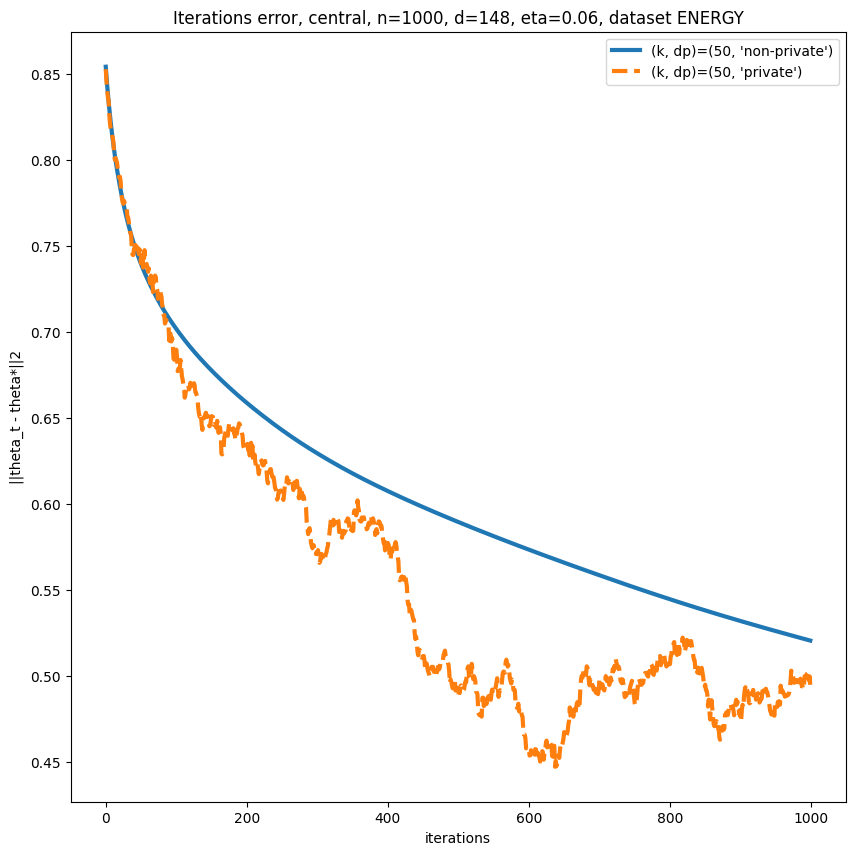

In [211]:
utils.plot_error_by_iteration_and_dict_key(
    result_energy,
    title=f'Iterations error, central, n={n}, d={d}, eta={eta}, dataset ENERGY',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(k, dp)")

## RCV1 Dataset (47k features)

In [84]:
from sklearn.datasets import fetch_rcv1

In [85]:
rcv1 = fetch_rcv1()

AttributeError: head

In [237]:
rcv1.data[:2000, :500].shape

(2000, 500)

In [240]:
df_rcv1 = pd.DataFrame.sparse.from_spmatrix(rcv1.data[:2000, :500], columns=[f'col{i}' for i in range(500)])

In [241]:
a, b = -1, 1
for column in df_rcv1.columns:
    df_rcv1[column] = a + ((df_rcv1[column] - df_rcv1[column].min()) * (b - a) / (df_rcv1[column].max() - df_rcv1[column].min()))
  
# view normalized data    
df_rcv1 = df_rcv1.fillna(0)
display(df_rcv1)

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col490,col491,col492,col493,col494,col495,col496,col497,col498,col499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0


In [244]:
df_rcv1.max()

col0      0.0
col1      0.0
col2      0.0
col3      0.0
col4      0.0
         ... 
col495    0.0
col496    0.0
col497    1.0
col498    0.0
col499    0.0
Length: 500, dtype: float64

In [ ]:
X = df_rcv1.sample(n=n)

In [115]:
y = rcv1.target.toarray()[:, 0]
X_rcv1 = rcv1.data[0:3000]
Y_rcv1 = y[0:3000]

In [119]:

Y_rcv1 = Y_rcv1.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [103]:
lso = Lasso(alpha=0.00001).fit(X_rcv1, Y_rcv1)
theta_star_rcv1 = lso.coef_

non_zero = [c for c in theta_star_rcv1 if c != 0]
len(non_zero)

724

In [120]:
T = 10
eta = 0.01
result_rcv1 = {}
n, d = X_rcv1.shape[0], X_rcv1.shape[1]

X_tensor = torch.tensor(X_rcv1)
Y_tensor = torch.tensor(Y_rcv1)
theta_star_tensor = torch.from_numpy(theta_star_energy)

data = (X_tensor, Y_tensor, theta_star_tensor)

for k in [700]:
    _, lmb = compute_noise_scale(k, eta, n, 1)

    # SLR non-private
    it_err, rel_error = sparse_linreg_peeling.solve(data, k, T, eta, (_, _, _, False))
    result_energy[(k, 'non-private')] = it_err
    print(f'[no noise] k={k}, last_err={it_err[-1]}')

    # SLR private
    # it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (lmb, T * 5, 1 / n, True))
    # result_energy[(k, 'private')] = it_err
    # print(f'[with noise] k={k}, last_err={last_err}')

RuntimeError: The size of tensor a (47236) must match the size of tensor b (148) at non-singleton dimension 0